In [73]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn
import time
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from matplotlib import cm
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

rcParams['figure.figsize'] = 20, 12


In [74]:
def plot_bidimensional(model, test, recon_error, layer, title):

    bidimensional_data = model.deepfeatures(test, layer).cbind(recon_error).as_data_frame()

    cmap = cm.get_cmap('Spectral')

    fig, ax = plt.subplots()
    bidimensional_data.plot(kind='scatter', 
                            x='DF.L{}.C1'.format(layer+1), 
                            y='DF.L{}.C2'.format(layer+1), 
                            s = 50,
                            c = 'Reconstruction.MSE',
                            title = title,
                            ax = ax,
                            colormap=cmap)
    layer_column = 'DF.L{}.C'.format(layer + 1)
    columns = [layer_column + '1', layer_column + '2']
    #for k, v in bidimensional_data[columns].iterrows():
    #    ax.annotate(k, v, size=5, verticalalignment='bottom', horizontalalignment='left')
    fig.canvas.draw()

In [75]:
import h2o
    
# Start H2O on your local machine
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 57 mins
H2O cluster version:,3.10.4.7
H2O cluster version age:,"21 days, 3 hours and 35 minutes"
H2O cluster name:,H2O_from_python_albertomariopirovano_f4o6rc
H2O cluster total nodes:,1
H2O cluster free memory:,1.611 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [158]:
X_train = h2o.import_file("../common/albertom/new_data/train_test/X_train.csv")
X_test = h2o.import_file("../common/albertom/new_data/train_test/X_test.csv")
y_train = h2o.import_file("../common/albertom/new_data/train_test/y_train.csv")
y_test = h2o.import_file("../common/albertom/new_data/train_test/y_test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [159]:
X_train = X_train.drop([0])
X_test = X_test.drop([0])
X_train = X_train[1:,:]
X_test = X_test[1:,:]
y_train = y_train.drop([0])
y_test = y_test.drop([0])
y_train = y_train[1:,:]
y_test = y_test[1:,:]

In [160]:
y_test_df = y_test.as_data_frame(True)

target_test_classes = y_test_df['C2'].values

In [161]:
X_train = X_train.cbind(y_train['C2'])

In [162]:
X_train_0 = X_train[X_train['C22'] == 0]
X_train_1 = X_train[X_train['C22'] == 1]

X_train_0 = X_train_0.drop(["C22"])
X_train_1 = X_train_1.drop(["C22"])

In [163]:
X_train_0

C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21
18.3124,0,9.44876,0,9.63561,0,9.3352,0,10.5907,0,11.1093,0,3.44822,1,0,0,0,1,0,1
6.64507,-2,1.69035,-2,1.52518,0,4.22016,0,4.70521,0,1.51225,0,3.55689,0,1,0,0,1,1,0
-5.6526,-1,5.5779,-1,2.18313,-1,3.12132,-1,2.67357,-1,1.92249e-05,1,3.68403,0,1,1,0,0,1,0
9.09218,0,2.65678,0,2.42107,0,2.83467,0,5.51065,0,3.79414,0,3.07232,0,1,0,0,1,0,1
12.2038,0,6.61318,0,6.74658,0,6.63786,0,15.1607,0,7.18764,2,3.73251,0,1,0,0,1,1,0
-4.58831,2,1.64754,-1,6.65809,0,5.08915,0,3.82155,-1,4.4731,0,3.03659,0,1,1,0,0,0,1
16.6837,0,4.11489,0,4.83662,0,4.06618,0,3.99461,0,4.78336,0,3.10723,1,0,0,0,1,0,1
15.5836,2,4.05956,2,5.16513,2,4.78292,0,4.71953,0,7.45424,0,2.9625,1,0,0,0,1,0,1
6.69222,-1,3.84497e-05,-2,0,-2,4.3777,-2,4.73598,0,5.30509,0,3.20753,1,0,0,1,0,0,1
0,0,5.26309,0,4.57648,0,6.99902,0,2.38667,0,2.60948,0,3,1,0,0,0,1,0,1


In [156]:
for i in np.arange(5):
    X_train_0 = X_train_0.rbind(X_train_0)

In [164]:
X_train_0.shape

(17799, 20)

In [165]:
seed = 13

model = H2OAutoEncoderEstimator(
    activation="Tanh",
    hidden=[8, 4, 2, 4, 8],
    epochs=100,
    #sparse=True,
    #l1=1e-5,
    #l2=1e-5,
    seed=seed,
    reproducible=True)

In [166]:
model.train(
    x=X_train_0.names,
    training_frame=X_train_0
)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


deepfeatures progress: |██████████████████████████████████████████████████| 100%


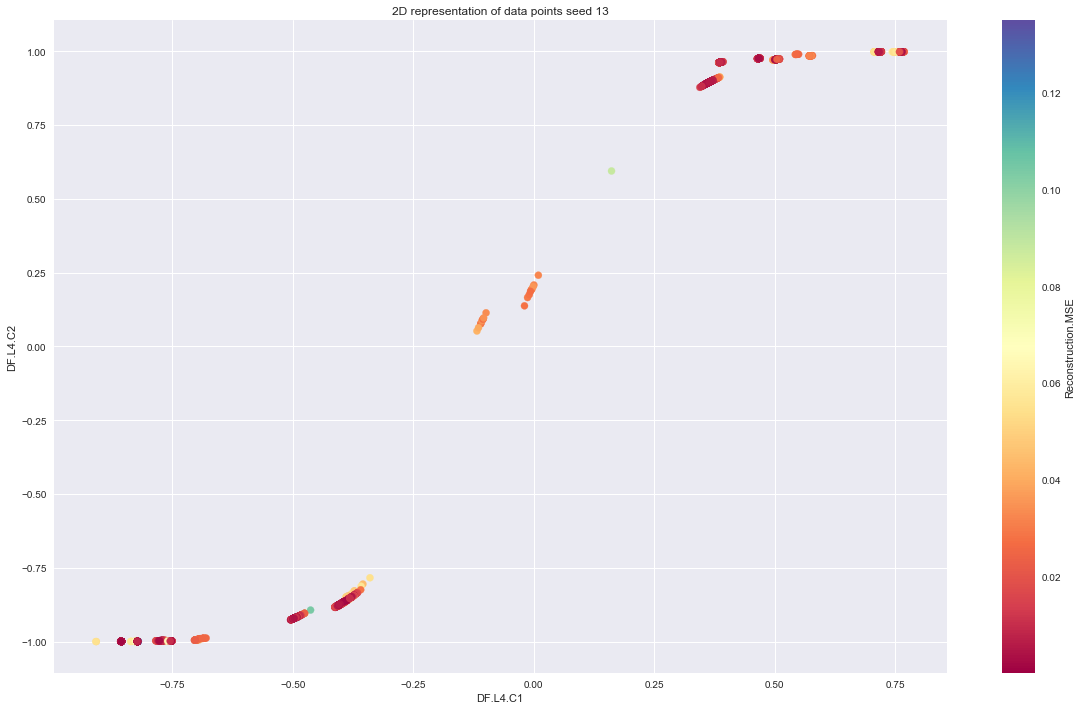

In [167]:
recon_error = model.anomaly(X_test)
plot_bidimensional(model, X_test, recon_error, 3, "2D representation of data points seed {}".format(seed))

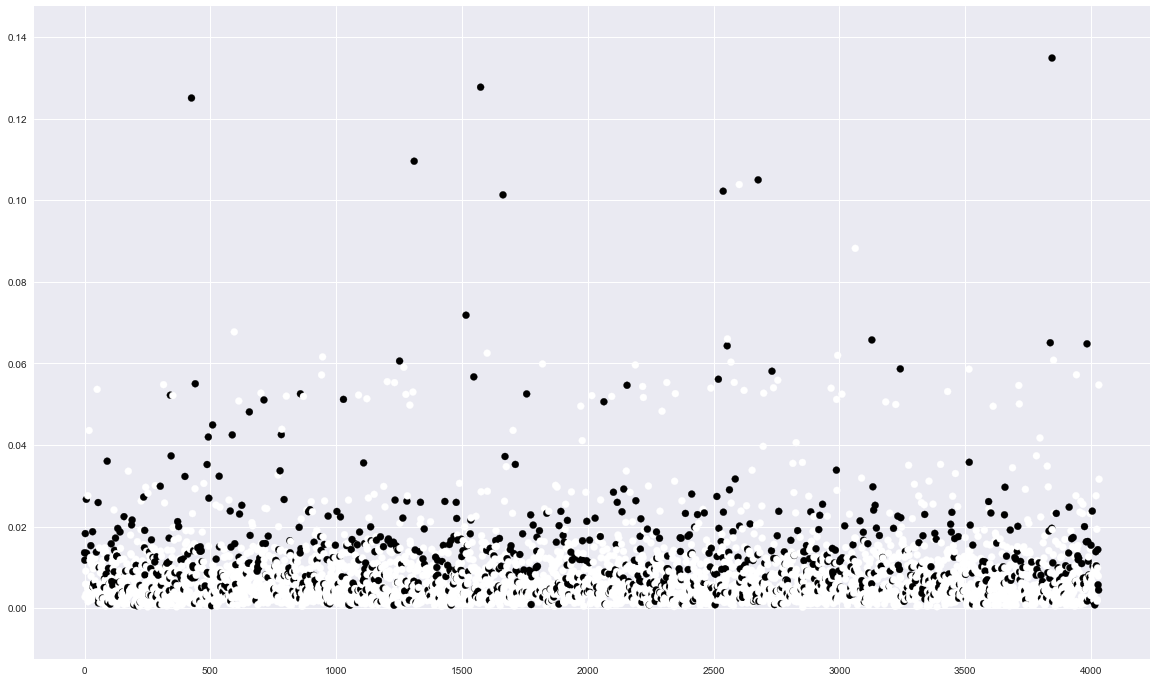

In [168]:
plt.figure()
df=recon_error.as_data_frame(True)
df["sample_index"]= df.index
df["TARGET"] = target_test_classes
fig, ax = plt.subplots()

ax.scatter(df["sample_index"].values, df["Reconstruction.MSE"].values, c=df["TARGET"])
df = df.drop(["TARGET"], axis=1)

plt.show()

In [132]:
def f(row):
    if row['bool'] == True:
        val = 1
    else:
        val = 0
    return val

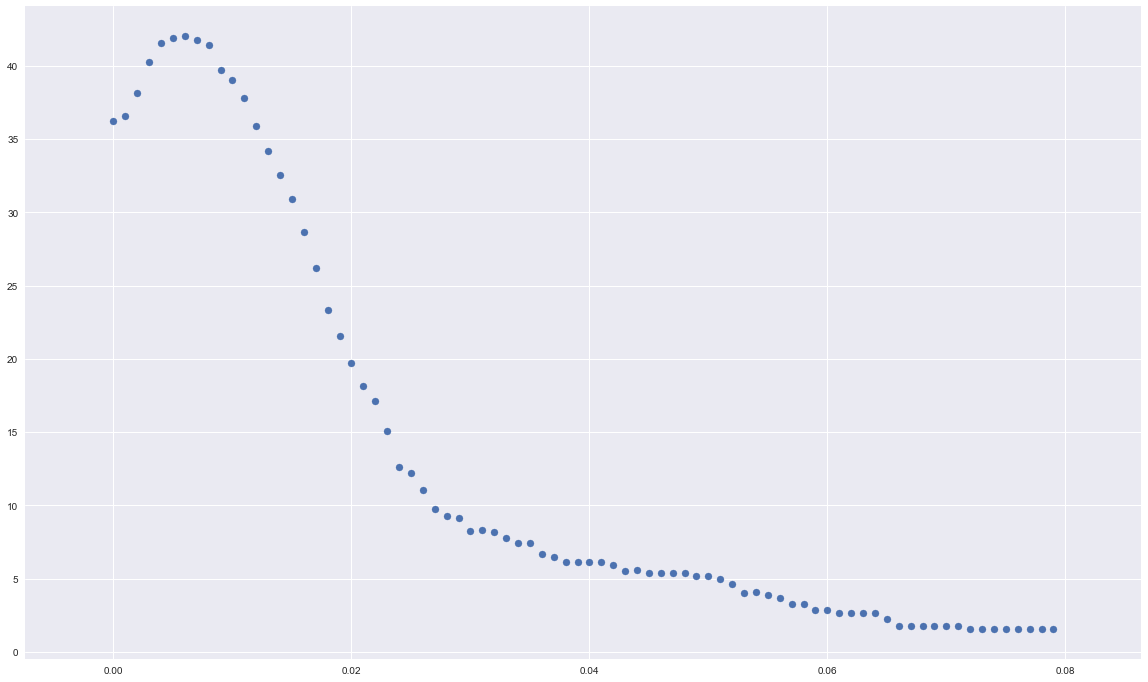

In [170]:
x = np.arange(0, 0.08, 0.001)
y = []

for threshold in x:
    
    df["bool"] = (df["Reconstruction.MSE"] > threshold)
    df['pred'] = df.apply(f, axis=1)
    df = df.drop("bool", axis=1)
    
    pred_classes = df["pred"].values
    y.append(100*f1_score(target_test_classes, pred_classes))

plt.scatter(x,y)

In [171]:
colors = {0:'r', 1:'b'}

threshold = 0.005

df["bool"] = (df["Reconstruction.MSE"] > threshold)
df["pred"] = df.apply(f, axis=1)
df = df.drop("bool", axis=1)

df["real"] = target_test_classes

pred_classes = df["pred"].values
real_classes = df["real"].values
print "F1: " + str(100*f1_score(real_classes,pred_classes))
print "Accuracy: " + str(100*accuracy_score(real_classes,pred_classes)) 

F1: 41.8822062948
Accuracy: 53.7565088024


In [172]:
df

,Reconstruction.MSE,sample_index,pred,real
0,0.013602,0,1,1
1,0.011777,1,1,1
2,0.002763,2,0,0
3,0.018299,3,1,1
4,0.005891,4,1,0
5,0.009090,5,1,0
6,0.003459,6,0,0
7,0.026702,7,1,1
8,0.013468,8,1,1
9,0.005737,9,1,0
